<a href="https://colab.research.google.com/github/Patela171/Pytorch/blob/main/PyTorch_Demo_Clothes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch # Imports PyTorch
from torch.utils.data import Dataset # Import PyTorch utilities for working with datasets
from torchvision import datasets # Premade datasets
from torchvision.transforms import ToTensor # Allows you to convert arrays to tensors (CPU -> Graphics Card)
import matplotlib.pyplot as plt # Import graphing mechanisms

# Download our training and testing data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 19137546.31it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 301658.42it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5432575.97it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23167679.18it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



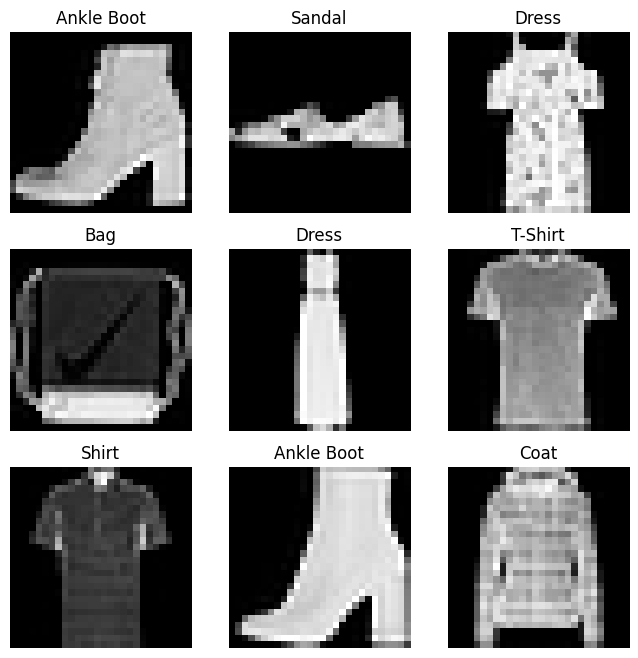

In [ ]:
# training_data[5]
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

img,label = training_data[12]

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  img, label = training_data[i]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#Dataloaders


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

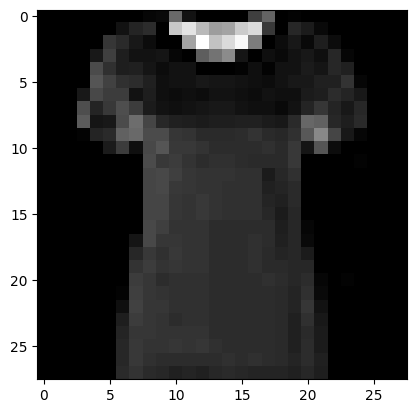

Label: 0


In [ ]:
train_features, train_labels = next(iter(train_dataloader))

# train_features.size()
# train_labels.size()
img = train_features[0].squeeze()
img
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

#Creating a Neural Network

In [ ]:
import torch.nn as nn # Import the libary neural network
import torch.nn.functional as F # Neural network (nn) functions
import torch.optim as optim # PyTorch optimizers, used for training

In [ ]:
class Net(nn.Module):
    def __init__(self): # Constructor
        super(Net, self).__init__() # Super constructor, runs the constructor from the super class
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5) # Layer 1, input, output, kernel size
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5) # Layer 2
        self.conv2_drop = nn.Dropout2d() # Layer 2 Options, drop layer, randomizes training patter
        self.fc1 = nn.Linear(320, 50) # Layer 3, input, output
        self.fc2 = nn.Linear(50, 10) # Layer 4, output must match the number of labels

    def forward(self, x): # Function, how information will go through our network
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # nn activation function, maxpooling helps to size down data (2x2 cube), speed up AI processing
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # If the value is negative, it returns 0, it its positive, it returns that value
        x = x.view(-1, 320)  # Resize data from 2 convolutional operators, forms 320 outputs
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) # Ignorable
        x = self.fc2(x)
        return F.log_softmax(x) # Takes the 10 nodes value (labels), returns probability that article of clothing is each of those clothings

In [ ]:
# CONSTANTS
n_epochs = 3 # How many times to iterate over all of the data when training
batch_size_train = 64 # Batch size
batch_size_test = 1000 # Test batch size
# Hyperparameters, can be changed to alter the results of training
learning_rate = 0.01 # How big the changes in our NN are after each training
momentum = 0.5 # How hard it is to change the direction of changes
log_interval = 10 # How often to print updates

random_seed = 1 # Random number generation
torch.backends.cudnn.enabled = False # Disabled because we are not using a NVIDIA Graphics Card
torch.manual_seed(random_seed)

In [ ]:
network = Net() # Initializes the network
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum) # Medium optimizer, best accuracy between positives and negatives

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_dataloader.dataset) for i in range(n_epochs + 1)]
# Loss is an output from optimizer, opposite of accuracy, you got stuff wrong

In [ ]:
def train(epoch):
  network.train() # Put our network into training mode
  # Iterate through all of our training data
  for batch_idx, (data, target) in enumerate(train_dataloader): # Iterate through our dataloader
    optimizer.zero_grad() # Reset our optimizer valeus
    output = network(data) # Push the images through our NN and get outputs
    loss = F.nll_loss(output, target) # Calculate loss
    loss.backward() # Use the loss to optimize our NN
    optimizer.step() # Step NN in the right direcion


    # Not very important
    # Every "log_interval" batches, print out some data
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_dataloader.dataset),
        100. * batch_idx / len(train_dataloader), loss.item()))

      # Data collection
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_dataloader.dataset)))
      # Save the NN so we can use it later
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  # Disable logging on our network, faster processing
  with torch.no_grad():
    # Iterate through all of our test data and see how many we got right
    for data, target in test_dataloader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  # Log results
  test_loss /= len(test_dataloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_dataloader.dataset),
    100. * correct / len(test_dataloader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-32-7e0867bd0c77>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # Takes the 10 nodes value (labels), returns probability that article of clothing is each of those clothings
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3033, Accuracy: 1016/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299620
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.314238
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.303632
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.316859
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.309018
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.320207
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.299803
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.295760
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.301694
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.291211
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.270047
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.288830
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.266785
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.248117
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.259385
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.203325
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.201733
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.205244
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.177819
Train Epoch: 1 [12160

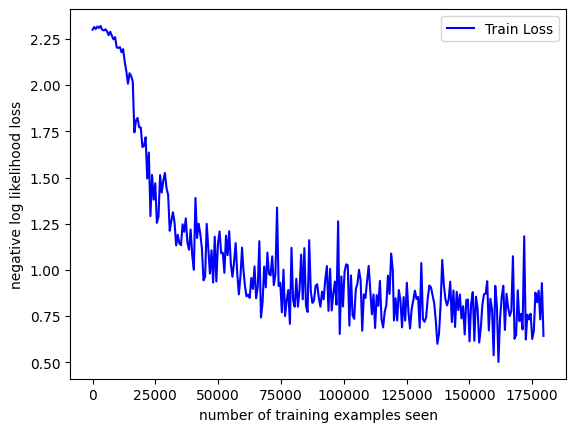

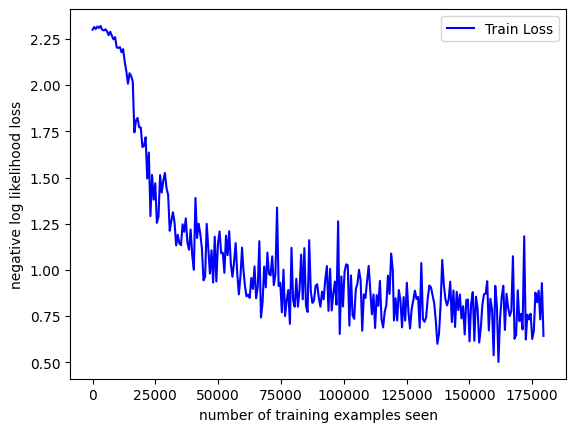

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

<ipython-input-32-7e0867bd0c77>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # Takes the 10 nodes value (labels), returns probability that article of clothing is each of those clothings


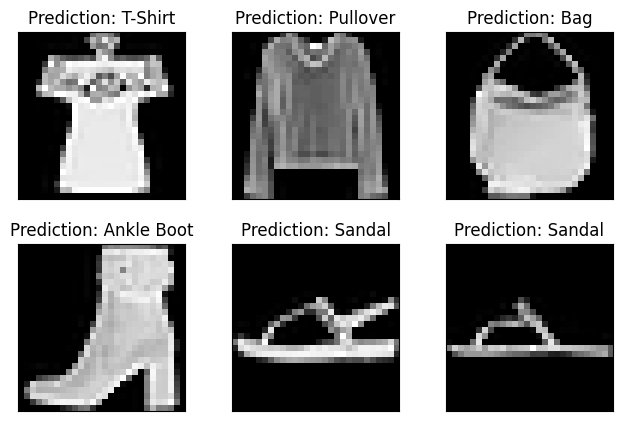

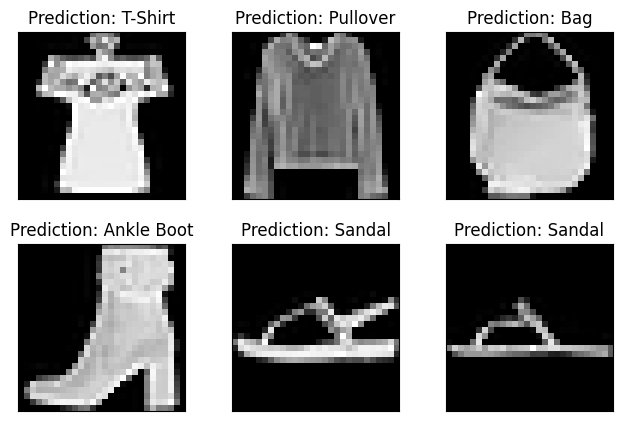

In [ ]:
# Get a batch from test dataset
examples = enumerate(test_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
# Disable gradients, run faster
with torch.no_grad():
  output = network(example_data) # Put the images through the NN

# Build a cool figure to show all the images
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(labels_map[
    output.data.max(1, keepdim=True)[1][i].item()]))
  plt.xticks([])
  plt.yticks([])
fig